<a href="https://colab.research.google.com/github/domi-n/projekt_inzynierski/blob/main/Dominika_Nowicka_projekt_in%C5%BCynierski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dominika Nowicka \\

projekt inżynierski

SPIS TREŚCI

>[Importowanie bibliotek](#scrollTo=_dNtPOZLb9gY)

>[Wczytywanie plików](#scrollTo=4uzvyZJScnaF)

>[Transformacja danych](#scrollTo=h2MzbiM3fbEk)

>>[Parametry](#scrollTo=m40WteHdfVtN)

>>[Rozpoznania](#scrollTo=kMP6vcu7lgmS)

>>[Procedury](#scrollTo=gz3MZ8ISpi4y)

>>[Recepty](#scrollTo=2x2Y9M1F5qV2)

>[Wykresy](#scrollTo=3kc-hl7pdHPf)

>>[Dane do wykresów](#scrollTo=GwR0N0_iKJ51)

>>[Funkcje wykresów](#scrollTo=iuOUxo_YX4b7)

>>>[Wykres przedstawiający ilosć próbek](#scrollTo=0exuZGtCLYKX)

>>>[Płeć pacjentów](#scrollTo=n8yNL5Av91f6)

>>>[Wiek pacjentów](#scrollTo=g0SRUXd197RD)

>>>[Rozpoznania](#scrollTo=AZyUCYnS8Y4q)

>>>[Recepty](#scrollTo=ubZjo73f3ni5)

>>>[Procedury](#scrollTo=SWfPDVyl-KI2)

>[Przygtowanie danych do modeli uczenia maszynowego](#scrollTo=_S1Iy2xTIIlV)

>[Testowanie wybranych modeli uczenia maszynowego](#scrollTo=bn6ZDuz3ToNc)

>>[Podział na zbiór treningowy i testowy](#scrollTo=20wyDInO8kv_)

>>[Resampling](#scrollTo=UKS2pPdA8rQN)

>>[Modele](#scrollTo=BSR5NeiH7b-s)

>>>[Las losowy](#scrollTo=N9K3xS2P7ml2)

>>>[Algorytm k-najbliższych sąsiadów](#scrollTo=3s9UNLti7yyW)

>>>[Naiwny klasyfikator bayesowski](#scrollTo=-hYCJlKY7-7I)

>>>[XGBoost](#scrollTo=lfbA93zj8Ts3)

>[Podsumowanie i wykresy](#scrollTo=oYH9mcG-27d0)

>>[Metryki na zbiorze testowym](#scrollTo=8zRW7QeT3Fqq)



# Importowanie bibliotek

In [ ]:
# transformacja danych

import pandas as pd
import numpy as np

# wizualizacja danych

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# uczenie maszynowe

from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

# inne
import random

# Wczytywanie plików

Pliki załączone bezpośrednio ze strony dane.ov.pl

link do zbioru danych: https://dane.gov.pl/pl/dataset/1711,zanonimizowana-probka-danych-nfz-dotyczaca-wystapienia-udaru-niedokrwiennego-mozgu

adnotacja: wczytywanie danych bezpośrednio ze strony może potrwać ponad 30 min

In [ ]:
pacjenci = pd.read_csv("https://api.dane.gov.pl/media/resources/20191009/pacjenci.csv", sep=';')
parametry = pd.read_csv("https://api.dane.gov.pl/media/resources/20191009/parametry_pacjentow.csv", sep=';')
procedury = pd.read_csv("https://api.dane.gov.pl/media/resources/20191009/procedury.csv", sep=';')
recepty = pd.read_csv("https://api.dane.gov.pl/media/resources/20191009/recepty.csv", sep=';', decimal=',')
rozpoznania = pd.read_csv("https://api.dane.gov.pl/media/resources/20191009/rozpoznania.csv", sep=';',  dtype = str)
swiadczenia = pd.read_csv("https://api.dane.gov.pl/media/resources/20191011/swiadczenia.zip", sep=';', encoding='cp1252')

<ipython-input-2-ed70160cccfd>:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  swiadczenia = pd.read_csv("https://api.dane.gov.pl/media/resources/20191011/swiadczenia.zip", sep=';', encoding='cp1252')


# Transformacja danych

## Parametry

In [ ]:
# kodowanie danych kategorycznych - każda kategoria jako kolumna, pomijając jedną / hot-one encoding

parametry_trans = pd.get_dummies(parametry, columns = ['GRUPA_WIEKOWA'], drop_first= True)
parametry_trans = pd.get_dummies(parametry_trans, columns = ['PLEC'], drop_first = True)

# usunięcie kolumny z powiatem

parametry_trans = parametry_trans.drop(columns = 'TERYT_POWIATU')

parametry_trans.head()

In [ ]:
parametry_wykres = parametry.merge(pacjenci, on = 'ID_PACJENTA', how='left')

In [ ]:
parametry_ = parametry_trans.copy()

## Rozpoznania

In [ ]:
# po ID_KONTAKTU można połączyć tabelę świadczenia z rozpoznaniami

id_kontaktu_swiadczenia = swiadczenia[['ID_PACJENTA', 'ID_KONTAKTU']]

rozpoznania['ID_KONTAKTU'] = rozpoznania['ID_KONTAKTU'].astype(int)

pacjenci_rozpoznania = id_kontaktu_swiadczenia.merge(rozpoznania, on='ID_KONTAKTU', how='left')

# skrócenie szczegółowości zaszyfrowanego rozpoznania

pacjenci_rozpoznania['KOD_ROZPOZNANIA_KROTKI'] = pacjenci_rozpoznania['KOD_ROZPOZNANIA'].astype(str).str[:2]

# transformacje

pacjenci_rozpoznania = pacjenci_rozpoznania.groupby(['ID_PACJENTA','KOD_ROZPOZNANIA_KROTKI']).size().to_frame('size').reset_index()
pacjenci_rozpoznania_pivot = pacjenci_rozpoznania.pivot(index='ID_PACJENTA', columns='KOD_ROZPOZNANIA_KROTKI', values='size')
pacjenci_rozpoznania_pivot= pacjenci_rozpoznania_pivot.rename_axis(None, axis=1)
pacjenci_rozpoznania_pivot = pacjenci_rozpoznania_pivot.fillna(0).astype(int)

pacjenci_rozpoznania_pivot[pacjenci_rozpoznania_pivot > 0] =int(1)

for col in pacjenci_rozpoznania_pivot.columns.tolist():
  pacjenci_rozpoznania_pivot.rename(columns={col: 'ROZPOZNANIE_' + str(col)}, inplace = True)

pacjenci_rozpoznania_pivot.head()

In [ ]:
# tabela do wykresów

rozpoznania_wykres = pacjenci_rozpoznania.merge(pacjenci, on = 'ID_PACJENTA', how='left')

## Procedury

Transformacja tabeli procedury może się odbyć tylko po zwiększeniu ilości jednostek obliczeniowych (pierwsza funkcja merge na tylu danych wymaga ponad 12,7 GB pamięci RAM)

In [ ]:
# po ID_EPIZODU można połączyć tabelę świadczenia z procedurami

id_epizodu_swiadczenia = swiadczenia[['ID_PACJENTA', 'ID_EPIZODU']]

procedury['KOD_PROCEDURY_KROTKI'] = procedury['KOD_PROCEDURY'].astype(int)

pacjenci_procedury = id_epizodu_swiadczenia.merge(procedury, on='ID_EPIZODU', how='left')
pacjenci_procedury.dropna(subset=['KOD_PROCEDURY_KROTKI'], inplace=True)

# skrócenie szczegółowości zaszyfrowanej procedury

pacjenci_procedury['KOD_PROCEDURY_KROTKI'] = pacjenci_procedury['KOD_PROCEDURY'].astype(int)

# transformacje

pacjenci_procedury = pacjenci_procedury.groupby(['ID_PACJENTA','KOD_PROCEDURY_KROTKI']).size().to_frame('size').reset_index()
pacjenci_procedury_pivot = pacjenci_procedury.pivot(index='ID_PACJENTA', columns='KOD_PROCEDURY_KROTKI', values='size')
pacjenci_procedury_pivot= pacjenci_procedury_pivot.rename_axis(None, axis=1)
pacjenci_procedury_pivot = pacjenci_procedury_pivot.fillna(0).astype(int)

pacjenci_procedury_pivot[pacjenci_procedury_pivot > 0] = 1

for col in pacjenci_procedury_pivot.columns.tolist():
  pacjenci_procedury_pivot.rename(columns={col: 'PROCEDURA_' + str(col)}, inplace = True)

pacjenci_procedury_pivot.head()


In [ ]:
# tabela do wykresów

procedury_wykres = pacjenci_procedury.merge(pacjenci, on = 'ID_PACJENTA', how='left')

## Recepty

In [ ]:
# transformacje

recepty_kod = recepty[['ID_PACJENTA', 'KOD_ATC']]

pacjenci_recepty = recepty_kod.groupby(['ID_PACJENTA','KOD_ATC']).size().to_frame('size').reset_index()

pacjenci_recepty_pivot = pacjenci_recepty.pivot(index='ID_PACJENTA', columns='KOD_ATC', values='size')
pacjenci_recepty_pivot= pacjenci_recepty_pivot.rename_axis(None, axis=1)
pacjenci_recepty_pivot = pacjenci_recepty_pivot.fillna(0).astype(int)

pacjenci_recepty_pivot[pacjenci_recepty_pivot > 0] = 1

for col in pacjenci_recepty_pivot.columns.tolist():
  pacjenci_recepty_pivot.rename(columns={col: 'RECEPTA_' + str(col)}, inplace = True)


pacjenci_recepty_pivot.head()

<ipython-input-7-124a6ba91b5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recepty_kod['KOD_ATC_KROTKI'] = recepty_kod['KOD_ATC'].str[:1]


,RECEPTA_A01,RECEPTA_A02,RECEPTA_A03,RECEPTA_A04,RECEPTA_A05,RECEPTA_A06,RECEPTA_A07,RECEPTA_A08,RECEPTA_A09,RECEPTA_A10,...,RECEPTA_R06,RECEPTA_S01,RECEPTA_S02,RECEPTA_S03,RECEPTA_V01,RECEPTA_V03,RECEPTA_V04,RECEPTA_V06,RECEPTA_V07,RECEPTA_V20
ID_PACJENTA,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# tabela do wykresów
# skrócenie szczegółowości recepty

recepty_kod['KOD_ATC_KROTKI'] = recepty_kod['KOD_ATC'].str[:1]
recepty_kod = recepty_kod[recepty_kod['KOD_ATC_KROTKI'] != "-"]

recepty_wykres = recepty_kod.merge(pacjenci, on = 'ID_PACJENTA', how='left')

In [ ]:
recepty_ = pacjenci_recepty_pivot.copy().reset_index()

# Wykresy

## Dane do wykresów

In [ ]:
parametry_wykres = parametry_wykres[['ID_PACJENTA', 'GRUPA_WIEKOWA', 'PLEC', 'CZY_UDAR']]
rozpoznania_wykres = rozpoznania_wykres[['ID_PACJENTA','KOD_ROZPOZNANIA_KROTKI', 'CZY_UDAR']]
recepty_wykres = recepty_wykres[['ID_PACJENTA', 'KOD_ATC_KROTKI', 'CZY_UDAR']]
procedury_wykres = procedury_wykres[['ID_PACJENTA','KOD_PROCEDURY_KROTKI', 'CZY_UDAR']]

In [ ]:
dfs = [parametry_wykres, rozpoznania_wykres, recepty_wykres, procedury_wykres]

In [ ]:
dfs_true = []
dfs_false = []

for df in dfs:
  dfT = df[df['CZY_UDAR'] == True]
  dfT.drop_duplicates(inplace = True)
  dfs_true.append(dfT)
  dfF = df[df['CZY_UDAR'] == False]
  dfF.drop_duplicates(inplace = True)
  dfs_false.append(dfF)

<ipython-input-12-73814382a834>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfT.drop_duplicates(inplace = True)
<ipython-input-12-73814382a834>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfF.drop_duplicates(inplace = True)


## Funkcje wykresów


Funcja do rysowania wykresu słupkowego wykorzystywana w wizalizacji informacji na temat płci pacjentów

In [ ]:
def plot_plec(df, column_name, size, title, color):
  ax = sns.barplot(x=column_name, y=column_name, data=df, estimator=lambda x: len(x) / size * 100, color=color)
  ax.bar_label(ax.containers[0], fmt='%.2f%%')
  ax.set(ylabel="Procent (%)", xlabel="Płeć", title=title)
  ax.set(ylim=(0, 100))

Funkcja do rysowania wykresu słupkowego wykorzystywana w wizualizacji rozponań i recept

In [ ]:
def plot_stand(df, column_name, x_axis_name, true_false):
  value_counts = df[column_name].value_counts().to_frame().sort_index()
  labels = value_counts.index
  if true_false == True:
    sizes = value_counts / 2971 * 100
    title = "Pacjenci z udarem"
    color = 'sandybrown'
  else:
    sizes = value_counts / 497029 * 100
    title = "Pacjenci bez udaru"
    color = 'cornflowerblue'

  ax = sns.barplot(x=labels, y=column_name, data=sizes,  color=color)
  ax.set(ylabel="Procent (%)", xlabel=x_axis_name, title=title)
  ax.set(ylim=(0, 100))

Funkcja do rysowania wykresu słupkowego ze specjalną kolejnością etykiet wykorzystywana w wizualizacji wieku i procedur

In [ ]:
def plot_order(df, column_name, x_axis_name, true_false, figsize_x, figsize_y, order, percentage):
  value_counts = df[column_name].value_counts().to_frame().sort_index()
  labels = value_counts.index
  if true_false == True:
    sizes = value_counts / 2971 * 100
    title = "Pacjenci z udarem"
    color = 'sandybrown'
  else:
    sizes = value_counts / 497029 * 100
    title = "Pacjenci bez udaru"
    color = 'cornflowerblue'

  plt.figure(figsize=(figsize_x, figsize_y))

  ax = sns.barplot(x=labels, y=column_name, data=sizes, color=color, order=order)

  if percentage == True:
    ax.bar_label(ax.containers[0], fmt='%.2f%%')
  else:
    pass

  ax.set(ylabel="Procent (%)", xlabel=x_axis_name, title=title)
  ax.set(ylim=(0, 100))

### Wykres przedstawiający ilosć próbek

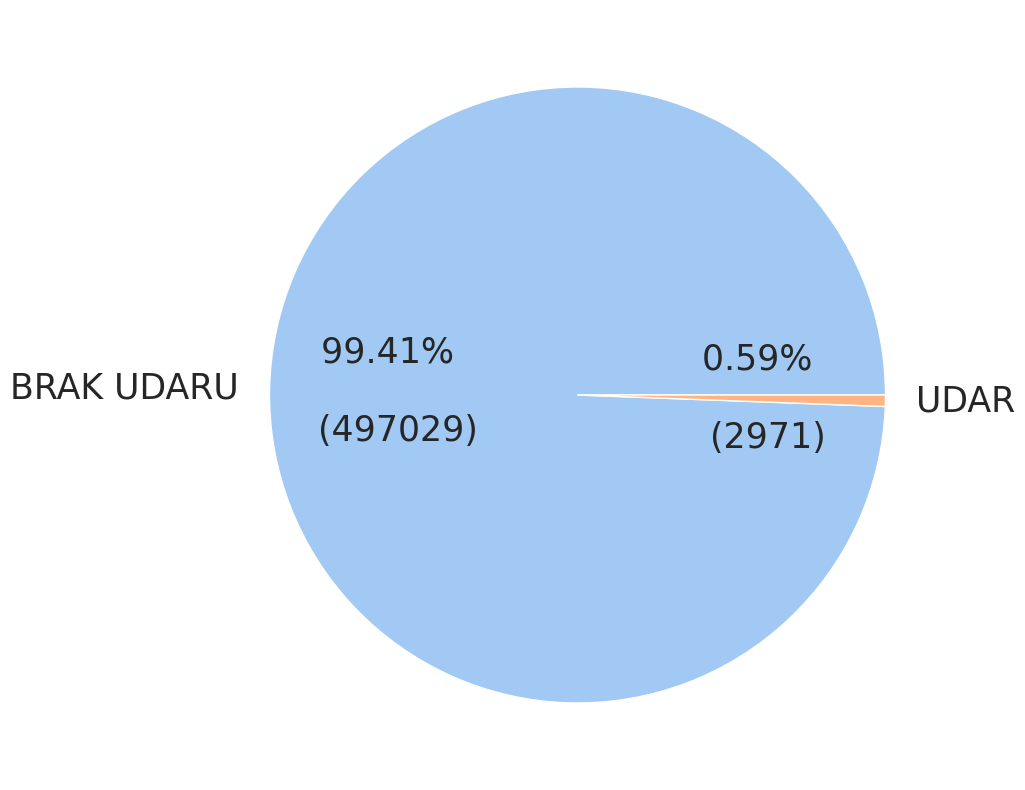

In [ ]:
# zdefiniowanie palety kolorów Seaborn oraz etykiet danych
colors = sns.color_palette('pastel')[0:2]
labels= ["BRAK UDARU", "UDAR"]
pac_size = pacjenci.groupby('CZY_UDAR').size()

# wykres kołowy - Pacjenci wg wystąpienia udaru
plt.figure(figsize=(10, 10))
plt.pie(pacjenci['CZY_UDAR'].value_counts(), labels=labels, colors = colors, autopct=lambda p: '{:.2f}% \n \n ({:.0f})'.format(p,(p/100)*pac_size.sum()), textprops={'fontsize': 25})

plt.show()

### Płeć pacjentów

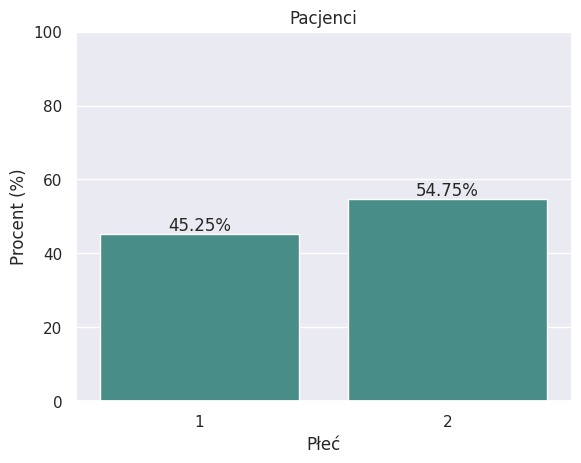

In [ ]:
plot_plec(parametry, "PLEC", 500000, "Pacjenci", '#3c9992')

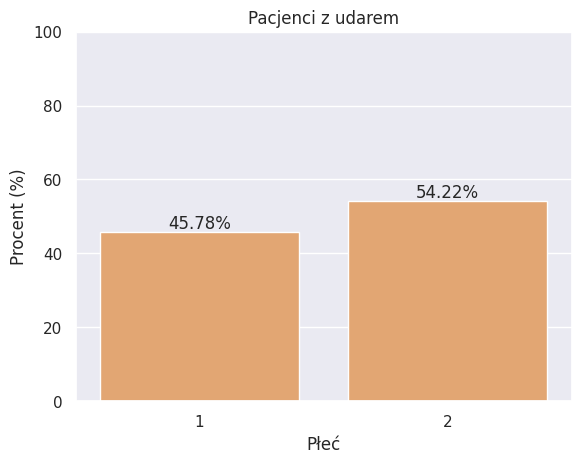

In [ ]:
plot_plec(dfs_true[0], "PLEC", 2971, "Pacjenci z udarem", 'sandybrown')

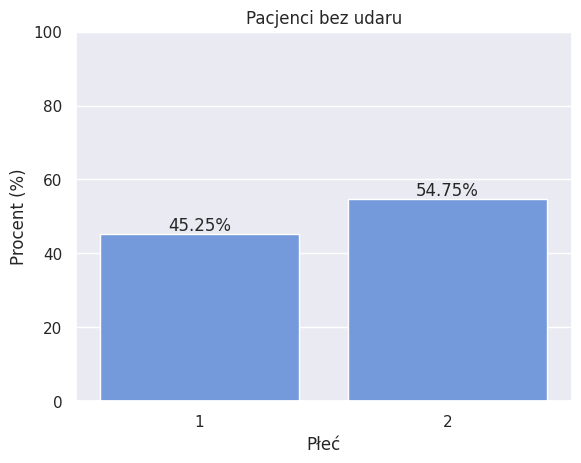

In [ ]:
plot_plec(dfs_false[0], "PLEC", 497029, "Pacjenci bez udaru", 'cornflowerblue')

### Wiek pacjentów

In [ ]:
order_wiek = ['[18,23]', '(23,28]', '(28,33]',
    '(33,38]', '(38,43]', '(43,48]', '(48,53]', '(53,58]', '(58,63]', '(63,68]', '(68,73]',
    '(73,78]', '(78,83]', '(83,88]', '(88,93]', '(93,98]', '(98,103]','(103,108]' ]

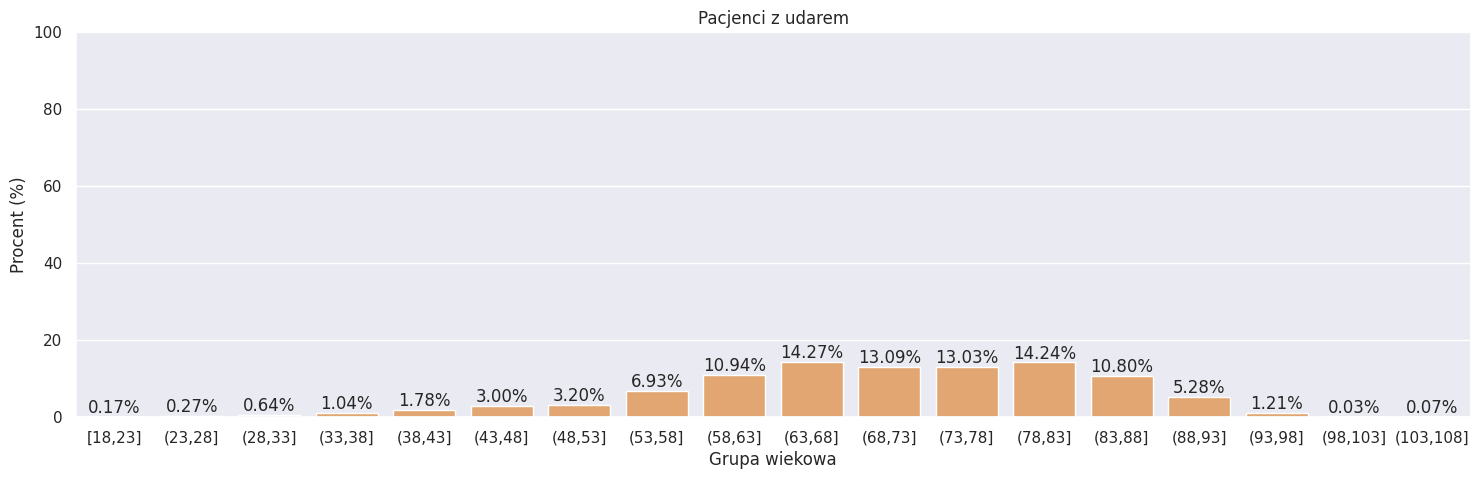

In [ ]:
plot_order(dfs_true[0], 'GRUPA_WIEKOWA', "Grupa wiekowa", True, 18, 5, order_wiek, True)

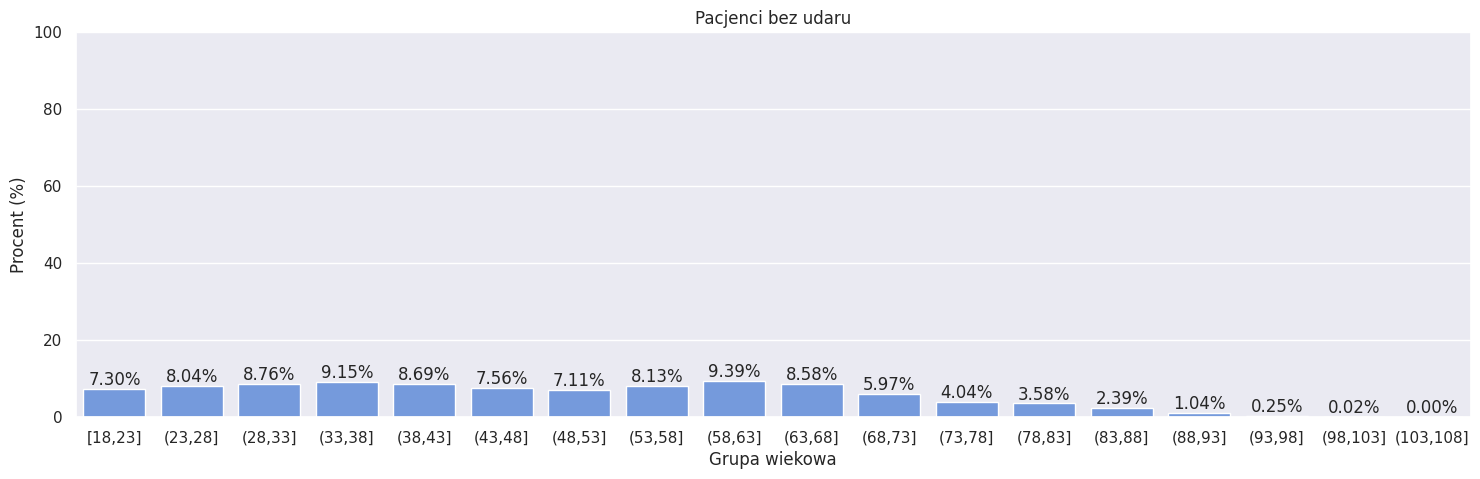

In [ ]:
plot_order(dfs_false[0], 'GRUPA_WIEKOWA', "Grupa wiekowa", False, 18, 5, order_wiek, True)

### Rozpoznania

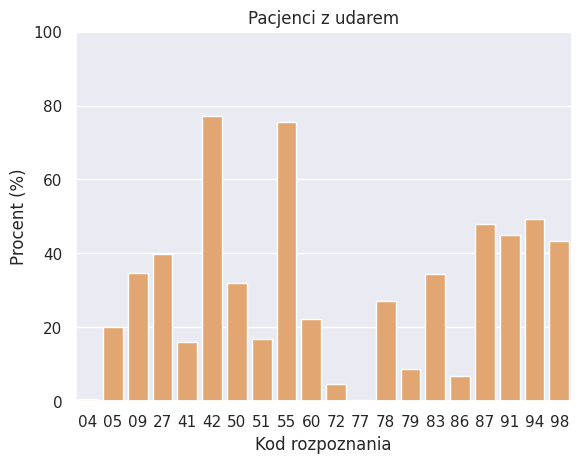

In [ ]:
plot_stand(dfs_true[1], "KOD_ROZPOZNANIA_KROTKI", "Kod rozpoznania", True)

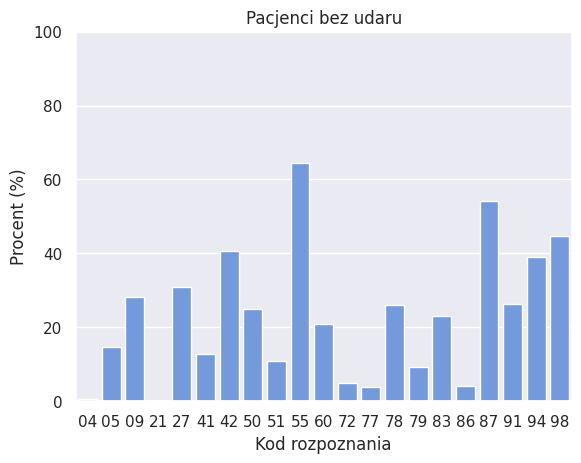

In [ ]:
plot_stand(dfs_false[1], "KOD_ROZPOZNANIA_KROTKI", "Kod rozpoznania", False)

### Recepty

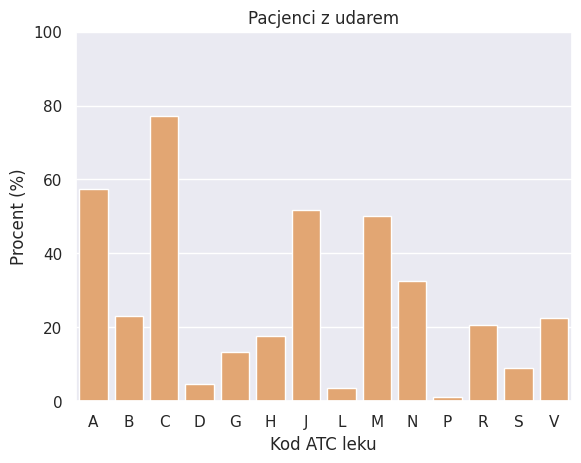

In [ ]:
plot_stand(dfs_true[2], 'KOD_ATC_KROTKI', "Kod ATC leku", True)

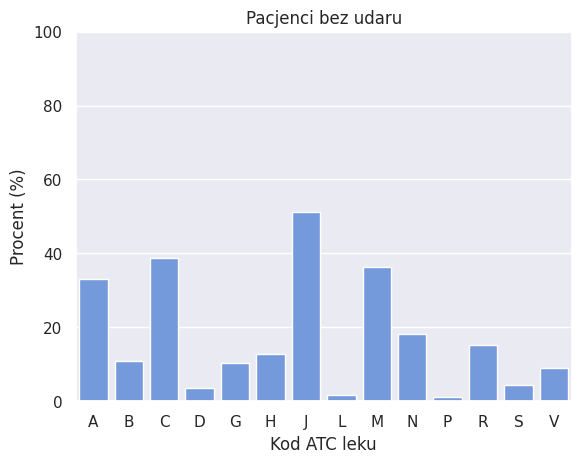

In [ ]:
plot_stand(dfs_false[2], 'KOD_ATC_KROTKI', "Kod ATC leku", False)

### Procedury

In [ ]:
order_procedury_true = dfs_true[3]["KOD_PROCEDURY_KROTKI"].value_counts().iloc[:20].index
order_procedury_false = dfs_false[3]["KOD_PROCEDURY_KROTKI"].value_counts().iloc[:20].index

In [ ]:
plot_order(dfs_true[3], 'KOD_PROCEDURY_KROTKI', "Kod procedury", True, 12, 5, order_procedury_true, False)

In [ ]:
plot_order(dfs_false[3], 'KOD_PROCEDURY_KROTKI', "Kod procedury", False, 12, 5, order_procedury_false, False)

# Przygtowanie danych do modeli uczenia maszynowego

Wybrane cechy z tabeli recepty

In [ ]:
filter = ['ID_PACJENTA', 'RECEPTA_C09', 'RECEPTA_J01','RECEPTA_M01','RECEPTA_C10','RECEPTA_A02','RECEPTA_C03','RECEPTA_C07',
          'RECEPTA_C08','RECEPTA_A10','RECEPTA_N02','RECEPTA_V04','RECEPTA_B01','RECEPTA_A12','RECEPTA_C01','RECEPTA_R03']

In [ ]:
recepty_ = recepty_[filter]

Złączenie tabeli recepty z tabelą parametry

In [ ]:
df = parametry_.merge(recepty_, on='ID_PACJENTA', how = 'inner')
df = df.merge(pacjenci[['ID_PACJENTA', 'CZY_UDAR']], on='ID_PACJENTA', how = 'left')
df.drop(columns = ['ID_PACJENTA'], inplace = True)

In [ ]:
df.columns

Index(['GRUPA_WIEKOWA_(108,113]', 'GRUPA_WIEKOWA_(23,28]',
       'GRUPA_WIEKOWA_(28,33]', 'GRUPA_WIEKOWA_(33,38]',
       'GRUPA_WIEKOWA_(38,43]', 'GRUPA_WIEKOWA_(43,48]',
       'GRUPA_WIEKOWA_(48,53]', 'GRUPA_WIEKOWA_(53,58]',
       'GRUPA_WIEKOWA_(58,63]', 'GRUPA_WIEKOWA_(63,68]',
       'GRUPA_WIEKOWA_(68,73]', 'GRUPA_WIEKOWA_(73,78]',
       'GRUPA_WIEKOWA_(78,83]', 'GRUPA_WIEKOWA_(83,88]',
       'GRUPA_WIEKOWA_(88,93]', 'GRUPA_WIEKOWA_(93,98]',
       'GRUPA_WIEKOWA_(98,103]', 'GRUPA_WIEKOWA_[18,23]', 'PLEC_2',
       'RECEPTA_C09', 'RECEPTA_J01', 'RECEPTA_M01', 'RECEPTA_C10',
       'RECEPTA_A02', 'RECEPTA_C03', 'RECEPTA_C07', 'RECEPTA_C08',
       'RECEPTA_A10', 'RECEPTA_N02', 'RECEPTA_V04', 'RECEPTA_B01',
       'RECEPTA_A12', 'RECEPTA_C01', 'RECEPTA_R03', 'CZY_UDAR'],
      dtype='object')

In [ ]:
df.shape

(412731, 35)

# Testowanie wybranych modeli uczenia maszynowego

## Podział na zbiór treningowy i testowy

In [ ]:
X = df.copy()
y = X.pop('CZY_UDAR')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
X_train.shape

(309548, 34)

In [ ]:
counter = Counter(y_train)
print(counter)

Counter({False: 307499, True: 2049})


In [ ]:
X_test.shape

(103183, 34)

In [ ]:
counter = Counter(y_test)
print(counter)

Counter({False: 102444, True: 739})


## Resampling

In [ ]:
over = SMOTE(sampling_strategy = 0.02, random_state=1)
under = RandomUnderSampler(random_state=1)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps = steps)

X_samp, y_samp = pipeline.fit_resample(X_train, y_train)

counter = Counter(y_samp)
print(counter)
print(X_samp.shape)

Counter({False: 6149, True: 6149})
(12298, 34)


Wykres przedstawiający ilość próbek po resamplingu

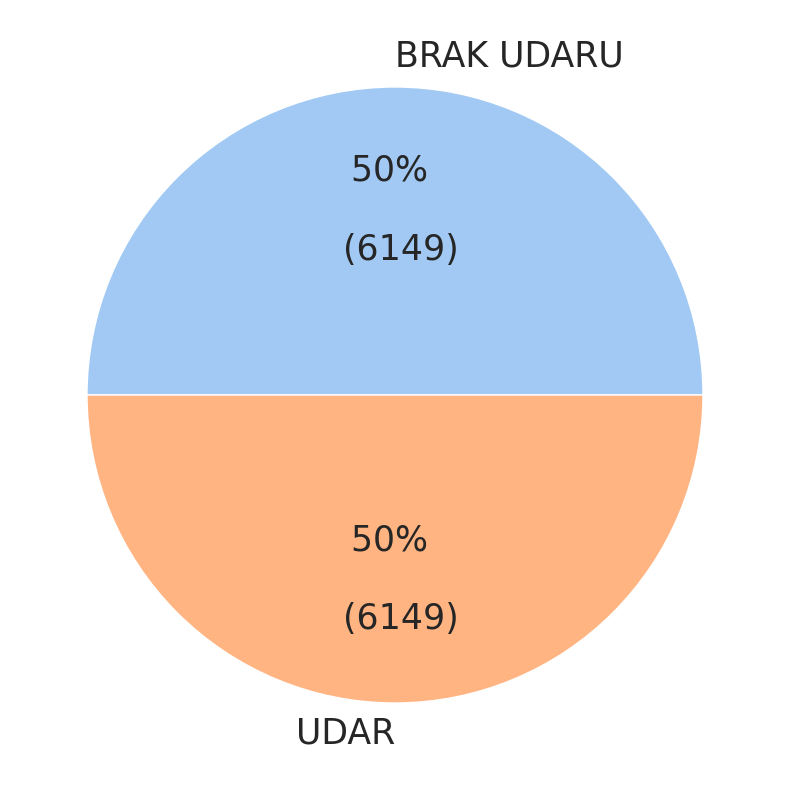

In [ ]:
value_counts = y_samp.value_counts()

colors = sns.color_palette('pastel')[0:2]
labels= ["BRAK UDARU", "UDAR"]

plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=labels, colors = colors, autopct=lambda p: '{:.0f}% \n \n ({:.0f})'.format(p,(p/100)*value_counts.sum()), textprops={'fontsize': 25})

plt.show()

## Modele

### Las losowy

Przeszukiwanie siatki

In [ ]:
# parameters =  {
#     'n_estimators': [500],
#                'max_depth': np.arange(1, 15),
#                 'min_samples_leaf': [2, 5, 10, 20, 50]}
#               # #  'min_samples_split':randint(1,50)
#               # }

# Grid_RFC_model = GridSearchCV(estimator = RandomForestClassifier(),
#                            param_grid = parameters,
#                            scoring = 'recall',
#                            cv = 10,
#                            n_jobs = -1,
#                            verbose = 2)

# Grid_RFC_model.fit(X_samp, y_samp)

# Grid_RFC_model.best_params_

Losowe przeszukiwanie siatki

In [ ]:
# parameters = {'criterion':('entropy', 'gini'),
# 'max_depth':random.randint(1, 10),
# 'min_samples_split':[random.randrange(0, 200, 10)],
# 'min_samples_leaf':[random.randrange(0, 200, 10)],
# 'max_leaf_nodes' : random.randint(1, 17)
# }


# rnd_clsf = RandomizedSearchCV(estimator=RandomForestClassifier(),
#                               param_distributions=parameters,
#                               n_iter=15,
#                               scoring = 'accuracy',
#                               cv=5,
#                               n_jobs=1,
#                               verbose=2)


# rnd_clsf.fit(X_samp, y_samp)

# rnd_clsf.best_params_

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model = RandomForestClassifier(n_estimators = 500,  max_depth = 14, min_samples_leaf= 18, n_jobs=-1, random_state=1)

model.fit(X_samp, y_samp)

y_pred_train = model.predict(X_samp)
y_pred = model.predict(X_test)

accuracy.append(round(accuracy_score(y_samp, y_pred_train),4))
recall.append(round(recall_score(y_samp, y_pred_train),4))
roc_auc.append(round(roc_auc_score(y_samp, y_pred_train),4))
precision.append(round(precision_score(y_samp, y_pred_train),4))

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Random Forest TRAIN', 'Random Forest TEST']
result_RFC = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_RFC

,Accuracy,Recall,Roc_Auc,Precision
Random Forest TRAIN,0.7436,0.8335,0.7436,0.7065
Random Forest TEST,0.6377,0.8078,0.7222,0.0158


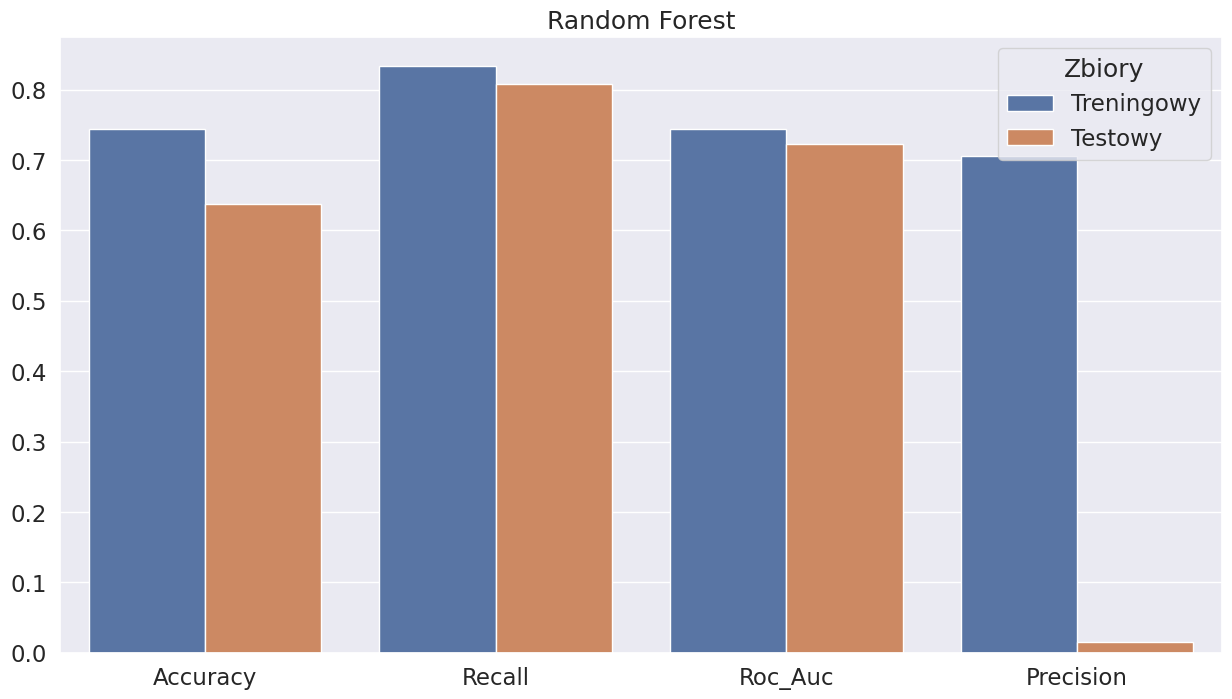

In [ ]:
result_RFC_T = result_RFC.transpose().reset_index()
result_RFC_T = result_RFC_T.rename(columns = {'Random Forest TRAIN': 'Treningowy', 'Random Forest TEST' : 'Testowy'})

sns.set(font_scale=1.5)

plt.figure(figsize=(15,8))
sns.barplot(x='index', y='value', hue='Zbiory',
            data=result_RFC_T.melt(id_vars='index', var_name='Zbiory', value_name='value'))

plt.xlabel(None)
plt.ylabel(None)
plt.title('Random Forest')

plt.show()

Text(0.5, 1.0, 'Random Forest')

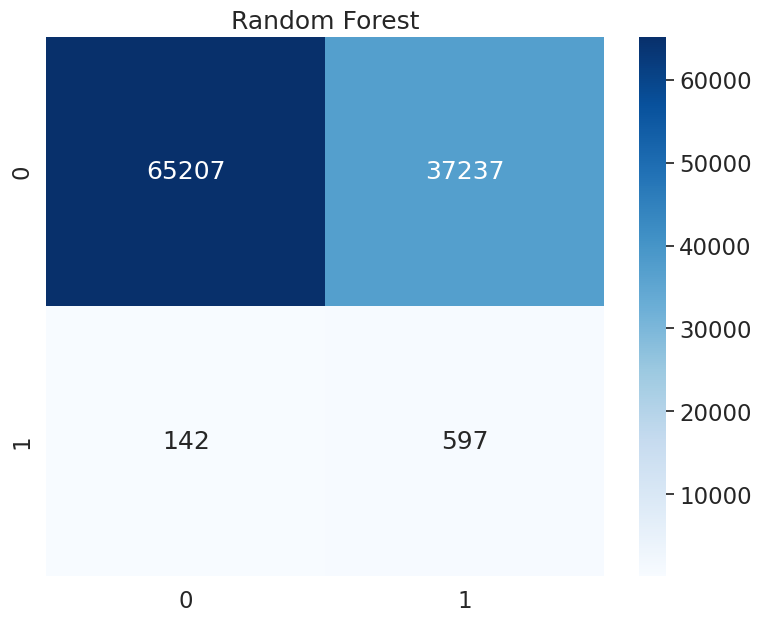

In [ ]:
plt.figure(figsize = (9,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap="Blues").set_title('Random Forest')

### Algorytm k-najbliższych sąsiadów

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model = KNeighborsClassifier(n_neighbors=29)

model.fit(X_samp, y_samp)

y_pred_train = model.predict(X_samp)
y_pred_knn = model.predict(X_test)

accuracy.append(round(accuracy_score(y_samp, y_pred_train),4))
recall.append(round(recall_score(y_samp, y_pred_train),4))
roc_auc.append(round(roc_auc_score(y_samp, y_pred_train),4))
precision.append(round(precision_score(y_samp, y_pred_train),4))

accuracy.append(round(accuracy_score(y_test, y_pred_knn),4))
recall.append(round(recall_score(y_test, y_pred_knn),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_knn),4))
precision.append(round(precision_score(y_test, y_pred_knn),4))

model_names = ['K Nearest Neighbors TRAIN', 'K Nearest Neighbors TEST']
result_KNN = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_KNN

,Accuracy,Recall,Roc_Auc,Precision
K Nearest Neighbors TRAIN,0.7599,0.8837,0.7599,0.7083
K Nearest Neighbors TEST,0.6162,0.7889,0.7019,0.0146


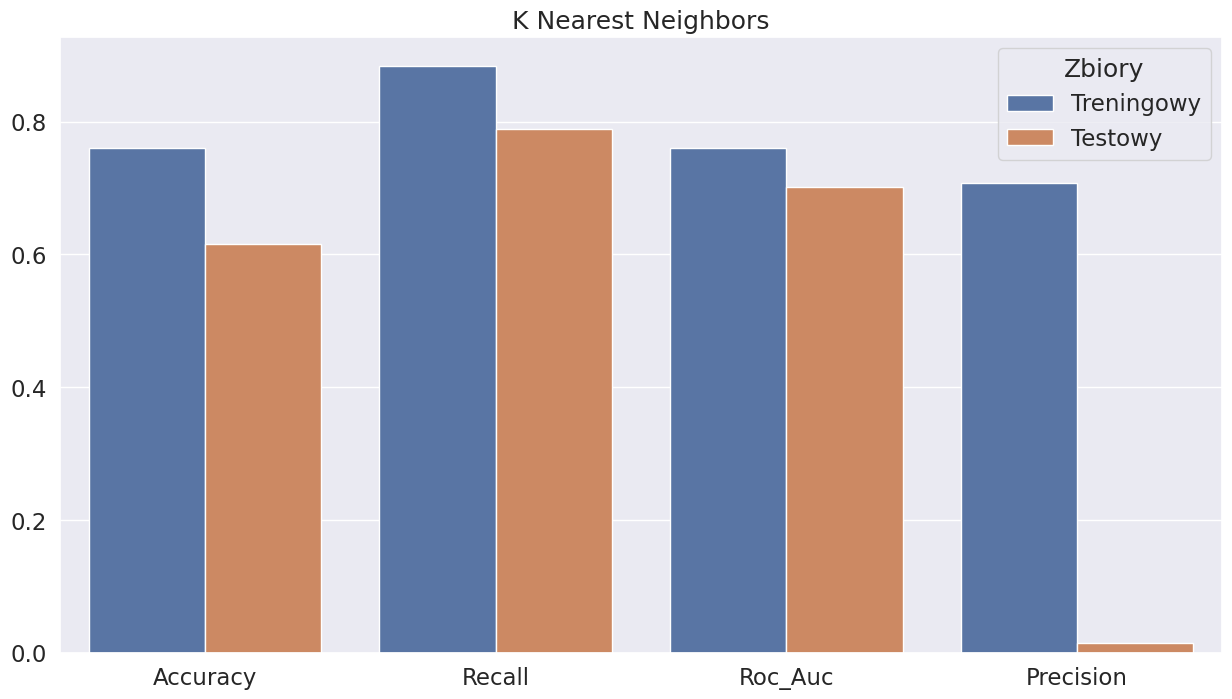

In [ ]:
result_KNN_T = result_KNN.transpose().reset_index()
result_KNN_T = result_KNN_T.rename(columns = {'K Nearest Neighbors TRAIN': 'Treningowy', 'K Nearest Neighbors TEST' : 'Testowy'})

sns.set(font_scale=1.5)

plt.figure(figsize=(15,8))
sns.barplot(x='index', y='value', hue='Zbiory',
            data=result_KNN_T.melt(id_vars='index', var_name='Zbiory', value_name='value'))

plt.xlabel(None)
plt.ylabel(None)
plt.title('K Nearest Neighbors')

plt.show()

Text(0.5, 1.0, 'K Nearest Neighbors')

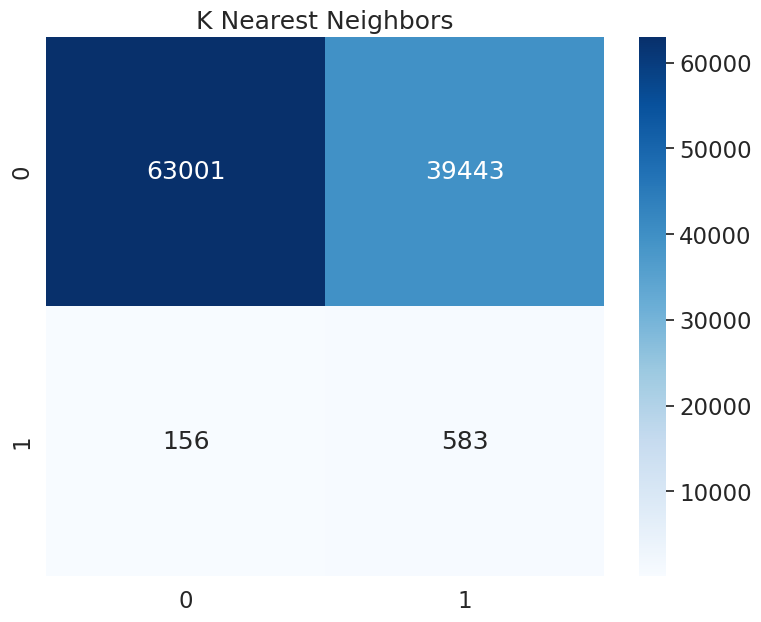

In [ ]:
plt.figure(figsize = (9,7))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='g', cmap="Blues").set_title('K Nearest Neighbors')

Porównanie recall i accuracy dla różnych parametrów

In [ ]:
# test_recall, test_accuracy= list(), list()


# values = [i for i in range(1, 100)]

# for i in values:

#  model = KNeighborsClassifier(n_neighbors = i)

#  model.fit(X_samp, y_samp)


#  # evaluate on the test dataset
#  test_yhat = model.predict(X_test)
#  test_re = recall_score(y_test, test_yhat)
#  test_acc = accuracy_score(y_test, test_yhat)
#  test_recall.append(test_re)
#  test_accuracy.append(test_acc)

# plt.figure(figsize=(15, 8))

# plt.plot(values, test_recall, '-o', label='Recall')
# plt.plot(values, test_accuracy, '-o', label='Accuracy')
# plt.legend()

# plt.title('K Nearest Neighbor TEST')

# plt.show()


### Naiwny klasyfikator bayesowski

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model = GaussianNB()
model.fit(X_samp, y_samp)

y_pred_train = model.predict(X_samp)
y_pred_NB = model.predict(X_test)

accuracy.append(round(accuracy_score(y_samp, y_pred_train),4))
recall.append(round(recall_score(y_samp, y_pred_train),4))
roc_auc.append(round(roc_auc_score(y_samp, y_pred_train),4))
precision.append(round(precision_score(y_samp, y_pred_train),4))

accuracy.append(round(accuracy_score(y_test, y_pred_NB),4))
recall.append(round(recall_score(y_test, y_pred_NB),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_NB),4))
precision.append(round(precision_score(y_test, y_pred_NB),4))

model_names = ['Naive Bayes TRAIN', 'Naive Bayes TEST']
result_NB = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_NB

,Accuracy,Recall,Roc_Auc,Precision
Naive Bayes TRAIN,0.7149,0.9330,0.7149,0.6496
Naive Bayes TEST,0.4953,0.9066,0.6995,0.0127


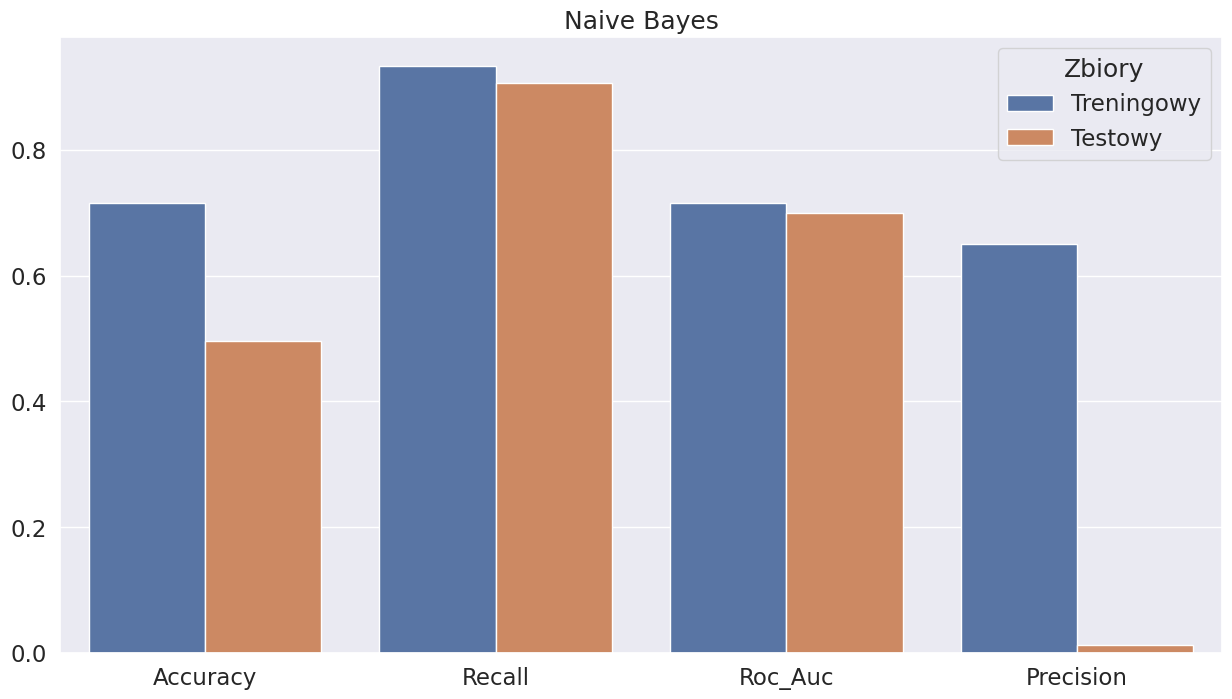

In [ ]:
result_NB_T = result_NB.transpose().reset_index()
result_NB_T = result_NB_T.rename(columns = {'Naive Bayes TRAIN': 'Treningowy', 'Naive Bayes TEST' : 'Testowy'})

sns.set(font_scale=1.5)

plt.figure(figsize=(15,8))
sns.barplot(x='index', y='value', hue='Zbiory',
            data=result_NB_T.melt(id_vars='index', var_name='Zbiory', value_name='value'))

plt.xlabel(None)
plt.ylabel(None)
plt.title('Naive Bayes')

plt.show()

Text(0.5, 1.0, 'Naive Bayes')

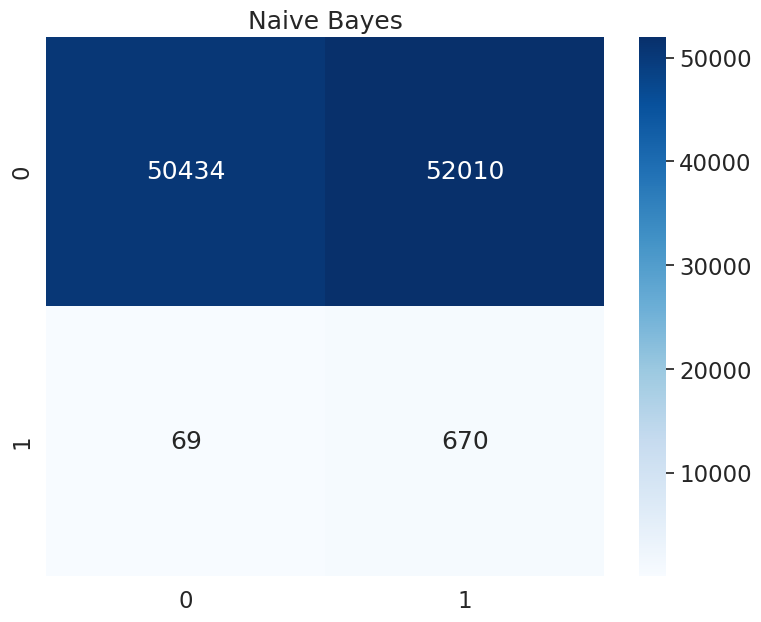

In [ ]:
plt.figure(figsize = (9,7))
sns.heatmap(confusion_matrix(y_test, y_pred_NB), annot=True, fmt='g', cmap="Blues").set_title('Naive Bayes')

### XGBoost

Zamiana niedozwolonych znaków w nazwach kolumn w XGBoost

In [ ]:
X_samp.columns = X_samp.columns.str.replace("]", "|")
X_samp.columns = X_samp.columns.str.replace("[", "|")
X_test.columns = X_samp.columns.str.replace("]", "|")
X_test.columns = X_samp.columns.str.replace("[", "|")

<ipython-input-55-ea22b2e6bdcd>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_samp.columns = X_samp.columns.str.replace("]", "|")
<ipython-input-55-ea22b2e6bdcd>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_samp.columns = X_samp.columns.str.replace("[", "|")
<ipython-input-55-ea22b2e6bdcd>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_test.columns = X_samp.columns.str.replace("]", "|")
<ipython-input-55-ea22b2e6bdcd>:4: FutureWarning: The default value of regex will change from True to False in a future v

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=500, random_state=1)

model.fit(X_samp, y_samp)

y_pred_train = model.predict(X_samp)
y_pred_XGBC = model.predict(X_test)

accuracy.append(round(accuracy_score(y_samp, y_pred_train),4))
recall.append(round(recall_score(y_samp, y_pred_train),4))
roc_auc.append(round(roc_auc_score(y_samp, y_pred_train),4))
precision.append(round(precision_score(y_samp, y_pred_train),4))

accuracy.append(round(accuracy_score(y_test, y_pred_XGBC),4))
recall.append(round(recall_score(y_test, y_pred_XGBC),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_XGBC),4))
precision.append(round(precision_score(y_test, y_pred_XGBC),4))

model_names = ['XGBoost TRAIN', 'XGBoost TEST']
result_XGBC = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_XGBC

,Accuracy,Recall,Roc_Auc,Precision
XGBoost TRAIN,0.7462,0.8559,0.7462,0.7019
XGBoost TEST,0.6253,0.8295,0.7267,0.0157


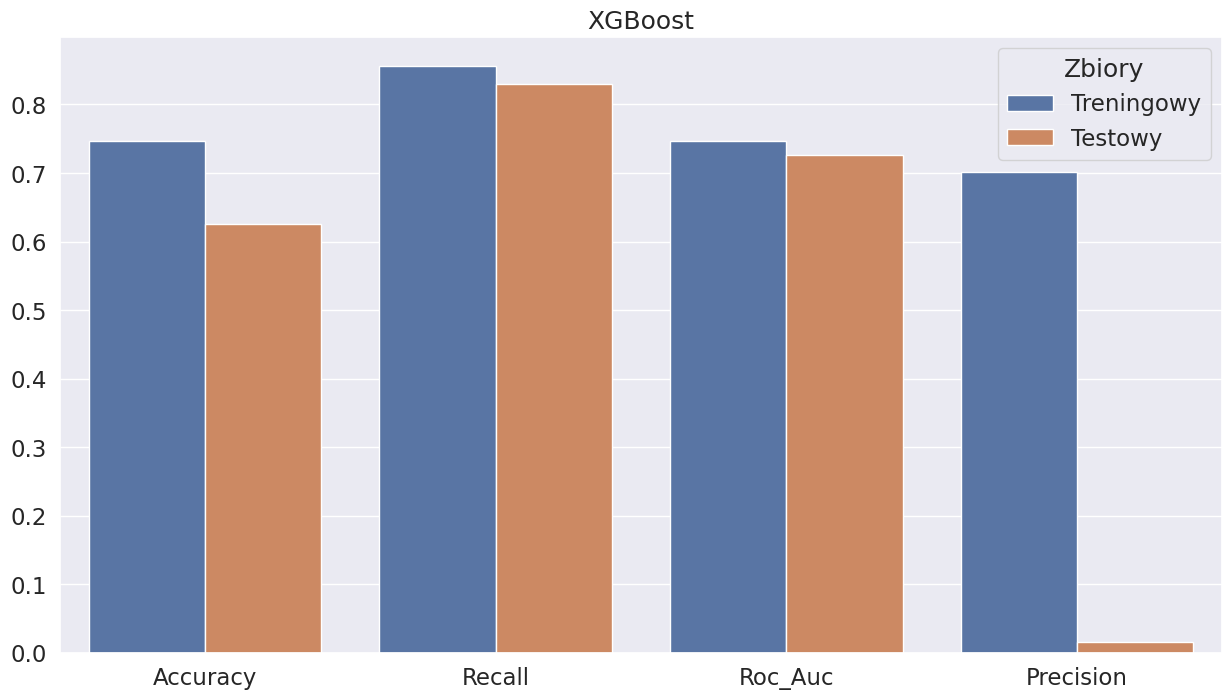

In [ ]:
result_XGBC_T = result_XGBC.transpose().reset_index()
result_XGBC_T = result_XGBC_T.rename(columns = {'XGBoost TRAIN': 'Treningowy', 'XGBoost TEST' : 'Testowy'})

sns.set(font_scale=1.5)

plt.figure(figsize=(15,8))
sns.barplot(x='index', y='value', hue='Zbiory',
            data=result_XGBC_T.melt(id_vars='index', var_name='Zbiory', value_name='value'))

plt.xlabel(None)
plt.ylabel(None)
plt.title('XGBoost')

plt.show()

Text(0.5, 1.0, 'XGBoost')

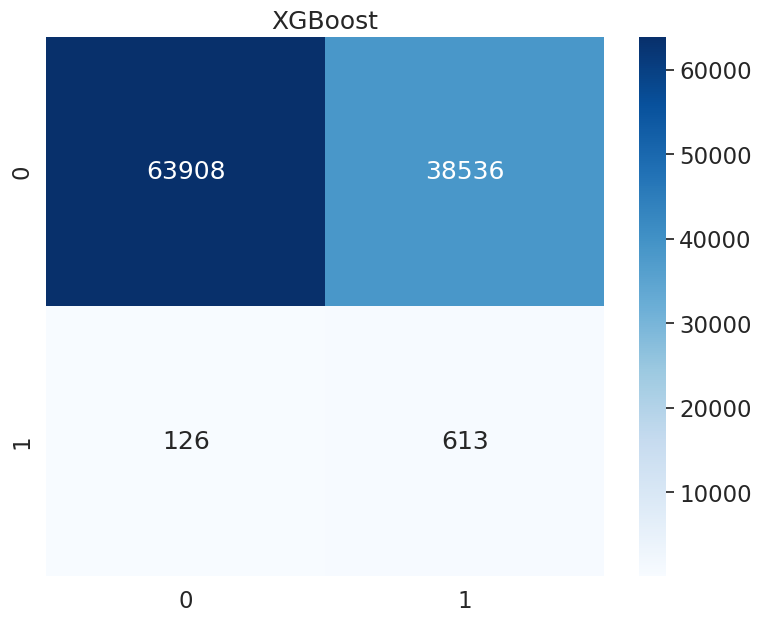

In [ ]:
plt.figure(figsize = (9,7))
sns.heatmap(confusion_matrix(y_test, y_pred_XGBC), annot=True, fmt='g', cmap="Blues").set_title('XGBoost')

# Podsumowanie i wykresy

## Metryki na zbiorze testowym

In [ ]:
all_metrics_test = pd.concat([result_RFC[1:], result_KNN[1:], result_NB[1:], result_XGBC[1:]])

In [ ]:
all_metrics_test

,Accuracy,Recall,Roc_Auc,Precision
Random Forest TEST,0.6377,0.8078,0.7222,0.0158
K Nearest Neighbors TEST,0.6162,0.7889,0.7019,0.0146
Naive Bayes TEST,0.4953,0.9066,0.6995,0.0127
XGBoost TEST,0.6253,0.8295,0.7267,0.0157


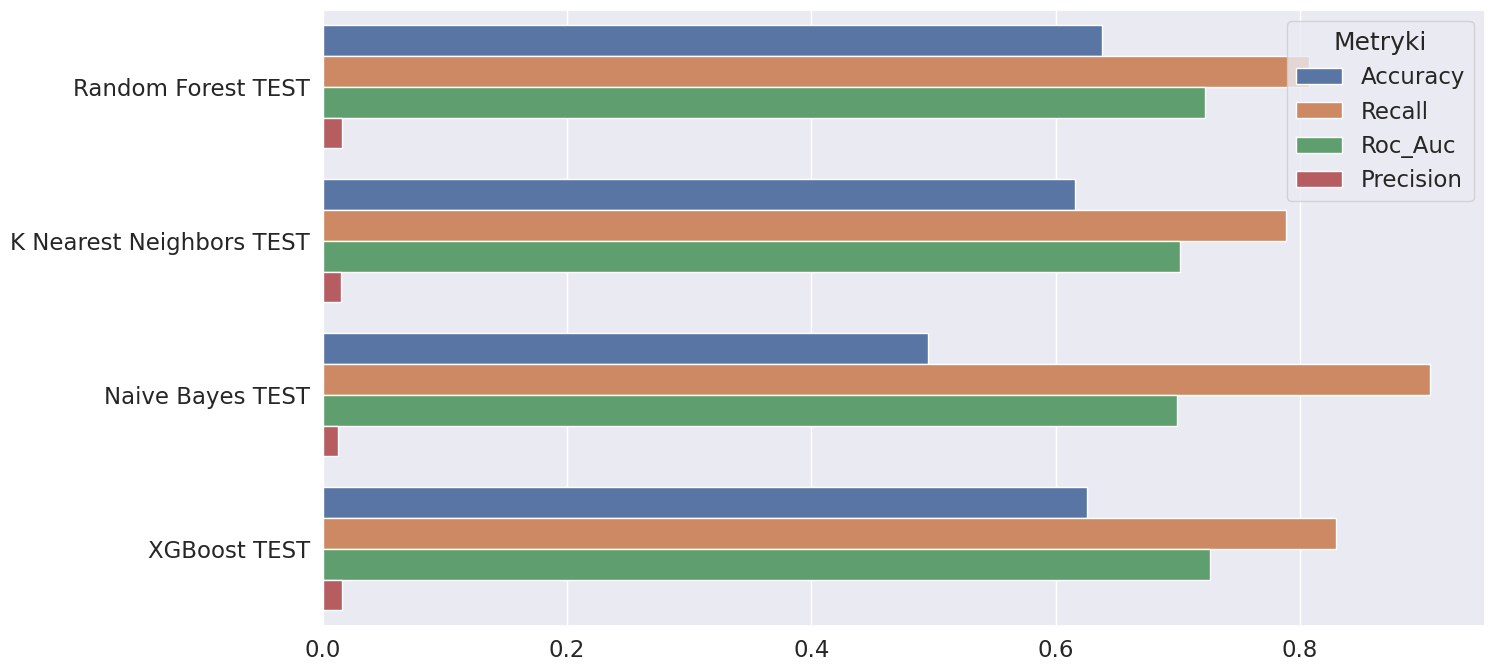

In [ ]:
all_metrics_test = all_metrics_test.reset_index()


plt.figure(figsize=(15,8))
sns.barplot(x='value', y='index', hue='Metryki',
            data=all_metrics_test.melt(id_vars='index', var_name='Metryki', value_name='value'))

plt.xlabel(None)
plt.ylabel(None)

plt.show()